In [1]:
import psycopg2
import pandas as pd
from psycopg2 import sql
from psycopg2.extras import execute_values
from sklearn.decomposition import TruncatedSVD
from joblib import dump, load
from sklearn.metrics.pairwise import cosine_similarity

from board_utils import *

In [2]:
def get_keys_func(board_vec):
    self_material_count = int(sum(board_vec[780:785] * [0,6,6,10,9]))
    opp_material_count = int(sum(board_vec[785:790] * [0,6,6,10,9]))
    diff_material_count = self_material_count - opp_material_count
    self_castle_available = int(sum(board_vec[768:770]) > 0)
    opp_castle_available = int(sum(board_vec[770:772]) > 0)
    position_in_endgame = int(sum(board_vec[780:790] * [0,2,2,2,1,0,2,2,2,1]) < 6)
    return self_material_count, opp_material_count, diff_material_count, self_castle_available, opp_castle_available, position_in_endgame

In [3]:
query_fen = 'r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 2 12' #carlsbad
#query_fen = 'rnb2b1r/2Nnkppp/p2pp3/8/PPBN1P2/2p3Pq/4Q2P/R3K1R1 w Q - 1 17' #wild opening
#query_fen = '6k1/5p2/1r2p1p1/3p1n2/3P3p/1P1R3P/4NPP1/6K1 b - - 2 36' #knight rook endgame
query_array = board_to_array(chess.Board(fen=query_fen))
query_array = orient_board(query_array, query_fen.split()[1]=='w')

keys = get_keys_func(query_array)
sm, om, dm, sc, oc, pe = keys

In [4]:
def get_position_recommendations(read_lim, write_lim, explain=False):

    svd = load('orient_svd_model.joblib')
    query_reduced = svd.transform(query_array[:790].reshape(1,-1))[0]

    query_array_sql = ' '.join(f'SELECT {i+1} AS idx, {value} AS value UNION ALL' for i, value in enumerate(query_reduced))
    query_array_sql = query_array_sql[:-9]

    query = f'''
    WITH provided_array AS (
        {query_array_sql}
    ),
    filtered_positions AS (
        SELECT position_id, svd_vector FROM positions
        WHERE self_material_count < {sm+5.5} AND self_material_count > {sm-5.5} 
        AND opp_material_count < {om+5.5} AND opp_material_count > {om-5.5} 
        AND diff_material_count < {dm+1.5} AND diff_material_count > {dm-1.5} 
        AND (self_castle_available = {sc} OR opp_castle_available = {oc})
        AND position_in_endgame = {pe}
    ),
    limited_positions AS (
        SELECT position_id, svd_vector
        FROM filtered_positions
        ORDER BY position_id LIMIT {read_lim}
    ),
    svd_vectors AS (
        SELECT lp.position_id, idx, value
        FROM limited_positions lp,
        LATERAL unnest(lp.svd_vector) WITH ORDINALITY AS u(value, idx)
    ),
    dot_products AS (
        SELECT v.position_id,
            SUM(v.value * p.value) AS dot_product
        FROM svd_vectors v
        JOIN provided_array p ON v.idx = p.idx
        GROUP BY v.position_id
    ),
    magnitudes AS (
        SELECT position_id,
            SQRT(SUM(value * value)) AS svd_vector_magnitude
        FROM svd_vectors
        GROUP BY position_id
        UNION ALL
        SELECT -1 AS position_id,
            SQRT(SUM(value * value)) AS svd_vector_magnitude
        FROM provided_array
    ),
    cosine_similarity AS (
        SELECT d.position_id,
            d.dot_product / (m1.svd_vector_magnitude * m2.svd_vector_magnitude) AS cos_sim
        FROM dot_products d
        JOIN magnitudes m1 ON d.position_id = m1.position_id
        JOIN magnitudes m2 ON m2.position_id = -1
    ),
    top_cosine_similarity AS (
    SELECT position_id, cos_sim
    FROM cosine_similarity
    ORDER BY cos_sim DESC
    LIMIT {write_lim}
    )
    SELECT p.vector_int, p.vector_float, p.position_id, tcs.cos_sim
    FROM positions p
    JOIN top_cosine_similarity tcs ON p.position_id = tcs.position_id
    '''
    if explain:
        query_prefix = 'EXPLAIN '
        #query_prefix = 'EXPLAIN ANALYZE '
    else:
        query_prefix = ''

    return query_prefix + query

In [5]:
conn = psycopg2.connect(
    dbname="capstone",
    user="postgres",
    password="postgres",
)

cur = conn.cursor()

In [6]:
read_lim = 50_000_000 #50_000_000
write_lim = 640_000 #640_000
query = get_position_recommendations(read_lim, write_lim, explain=True)
cur.execute(query)
plan = cur.fetchall()
plan

C:\Users\Jim\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[('Nested Loop  (cost=4058692.03..4058966.51 rows=32 width=185)',),
 ('  CTE provided_array',),
 ('    ->  Append  (cost=0.00..0.48 rows=32 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (cost=0.00..0.01 rows=1 width=36)',),
 ('          ->  Result  (c

In [7]:
read_lim = 8_000_000 #8_000_000
write_lim = 64_000 #64_000
rec_lim = 64
query = get_position_recommendations(read_lim, write_lim)

cur.execute(query)
matches = cur.fetchall()

positions = csr_matrix(np.vstack([np.array(t[0]+t[1]) for t in matches]))
ids = np.array([t[2] for t in matches])
cos_sims = np.array([t[3] for t in matches])

C:\Users\Jim\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
model_save_path = 'chess_cnn_model.pth'

model = ChessCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

try:
    checkpoint = torch.load(model_save_path, map_location=device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.load_state_dict(checkpoint['model_state_dict'])
except:
    print('model path not found')

In [9]:
def CNN_cosine_similarity(model, query_tensor, position_tensors):
    model.eval()
    with torch.no_grad():
        query_tensor = query_tensor.unsqueeze(0).to(device)
        position_tensors = position_tensors.to(device)
        query_tensor = query_tensor.to(next(model.parameters()).device)

        query_representation = model(query_tensor, return_intermediate=True).flatten(start_dim=1)
        position_representations = model(position_tensors, return_intermediate=True).flatten(start_dim=1)
        similarity = F.cosine_similarity(query_representation, position_representations, dim=1)
    return similarity.cpu().numpy()

In [10]:
model.to(device)

query_array = query_array[:768]
X_array = positions[:,:768].toarray()
X_array = X_array.reshape(len(X_array),12,8,8)

shape = (12,8,8)
query_tensor = torch.tensor(query_array, dtype=torch.float32).view(*shape)
position_tensors = torch.tensor(X_array, dtype=torch.float32).view(-1, *shape)

similarity = CNN_cosine_similarity(model, query_tensor, position_tensors)

In [11]:
themis_scale = {}
themis_scale['semantic'] = 100
themis_scale['dynamic'] = 100

In [12]:
semantic_weight = themis_scale['semantic'] / (themis_scale['semantic'] + themis_scale['dynamic'])
dynamic_weight = themis_scale['dynamic'] / (themis_scale['semantic'] + themis_scale['dynamic'])

In [13]:
normalized_semantic = (cos_sims - np.mean(cos_sims)) / np.std(cos_sims)
normalized_dynamic = (similarity - np.mean(similarity)) / np.std(similarity)

weighted_similarities = normalized_semantic * cos_sims + normalized_dynamic * similarity
more_semantic_inds = normalized_semantic > normalized_dynamic
sum(more_semantic_inds)
# prompt for good/bad suggestion, accordingly update themis_scale

28981

In [14]:
top_k_indices = np.argsort(weighted_similarities)[-rec_lim:][::-1]
cur = conn.cursor()
query = """
SELECT
    pos.position_id,
    p1.player_name AS white_player_name,
    p2.player_name AS black_player_name,
    g.white_elo,
    g.black_elo,
    g.white_title,
    g.black_title,
    g.event,
    g.site,
    g.date,
    g.round,
    g.result,
    g.opening,
    g.variation
FROM
    games g
JOIN
    positions pos ON g.game_id = pos.game_id
JOIN
    players p1 ON g.white_id = p1.player_id
JOIN
    players p2 ON g.black_id = p2.player_id
WHERE
    pos.position_id = %s;
"""

data = []
for pid in [int(ids[ind]) for ind in top_k_indices]:
    cur.execute(query, (pid,))
    result = cur.fetchone()
    if result:
        data.append(result)

columns = [
    "PositionID", "WhitePlayerName", "BlackPlayerName",
    "WhiteRating", "BlackRating", "WhiteTitle",
    "BlackTitle", "Event", "Site", "Date", "Round",
    "Result", "Opening", "Variation"
]

df = pd.DataFrame(data, columns=columns)
df = df.iloc[(df['WhiteRating'] + df['BlackRating']).argsort()[::-1]]
df = df.set_index('PositionID')
df.head()

,WhitePlayerName,BlackPlayerName,WhiteRating,BlackRating,WhiteTitle,BlackTitle,Event,Site,Date,Round,Result,Opening,Variation
PositionID,,,,,,,,,,,,,
25882098,"Carlsen, M",Ding Liren,2861,2805,GM,GM,Cote d'Ivoire Blitz 2019,Abidjan CIV,2019.05.12,12.3,1/2-1/2,Queen's bishop game,None
18539231,"Firouzja, Alireza","Paravyan, D",2728,2653,GM,GM,Katara Bullet Final 2020,lichess.org INT,2020.08.26,1.7,0-1,QGD,4.Nf3
21037164,"Esipenko, Andrey","Gelfand, B",2682,2676,GM,GM,PNWCC Online Blitz JP 10,chess.com INT,2020.05.16,8,1/2-1/2,QGD,"exchange, positional line, 5...c6"
11450812,"Bok, B","Bluebaum, M",2624,2674,GM,GM,Titled Tuesday 10th Aug,chess.com INT,2021.08.10,8,1-0,QGD,4.Nf3
18357302,"Esipenko, Andrey","Aleksandrov, A",2682,2608,GM,GM,Kurnosov Mem Rapid 2020,Chelyabinsk RUS,2020.09.06,10.10,1/2-1/2,QGD,"exchange, positional line, 5...c6"


r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 2 12


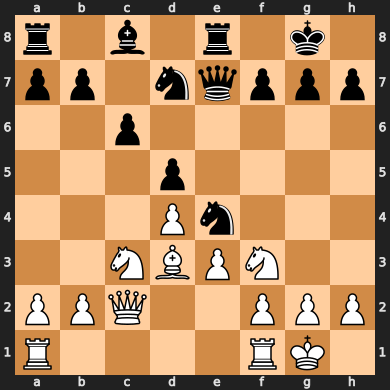

----------------------------------------------------------------
GM Bykhovsky (2405) - IM Arabidze (2428), Titled Tue 25th Aug (2020)
FEN: r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 8.191533014211696


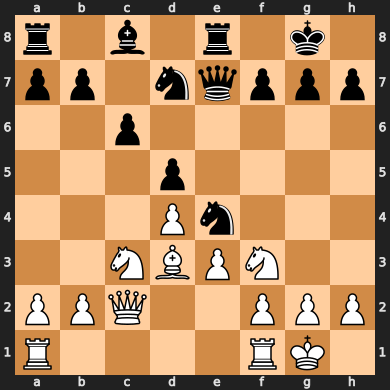

GM Jianu (2518) - IM Cosma (2368), TCh-ROU Rapid 2022 (2022)
FEN: r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/1R3RK1 w - - 0 1
Similarity: 7.802457988070507


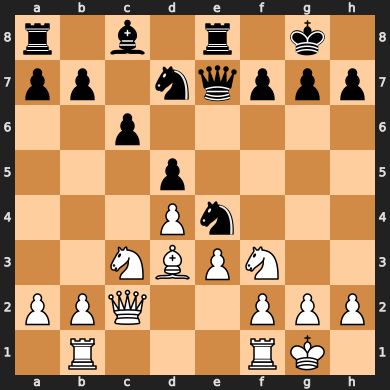

GM Pavlovic (2492) -  Robertson (2045), 19th ch-Euro Seniors +50 (2019)
FEN: r4rk1/ppqb1ppp/2nbpn2/3pN3/3P4/2PB4/PP1NQPPP/R1B1R1K1 b - - 0 1
Similarity: 7.285245091256395


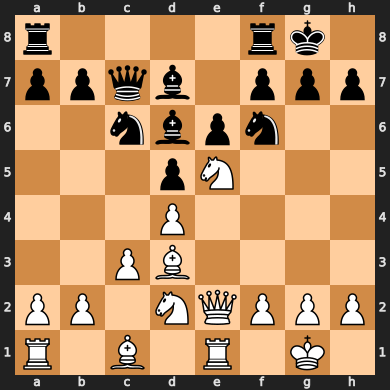

GM Koneru (2586) - IM Arabidze (2428), Online Olym Top DivA 2020 (2020)
FEN: r1b1rnk1/pp2qppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/1R3RK1 w - - 0 1
Similarity: 7.179694537029851


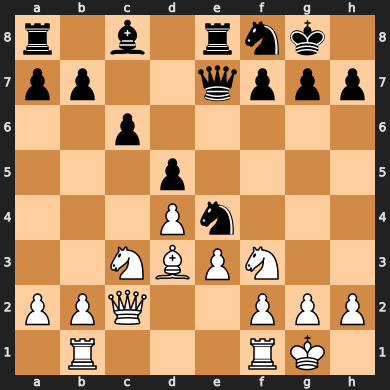

IM Niemann (2465) - GM Rychagov (2545), Titled Tuesday 16th June (2020)
FEN: r1b1rnk1/pp2qppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/1R3RK1 w - - 0 1
Similarity: 7.179694537029851


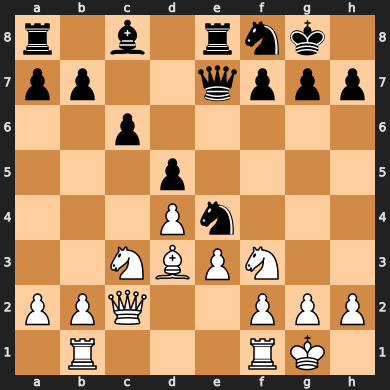

GM Lenderman (2634) - GM Narayanan (2618), Chess24 Banter QualD 2020 (2020)
FEN: r1b1rnk1/pp2qppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/1R3RK1 w - - 0 1
Similarity: 7.179694537029851


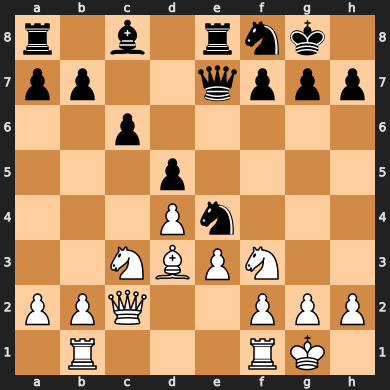

GM Lysyj (2603) - GM Rozum (2529), ch-RUS Rapid 2021 (2021)
FEN: r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/4RRK1 w - - 0 1
Similarity: 7.066007804440281


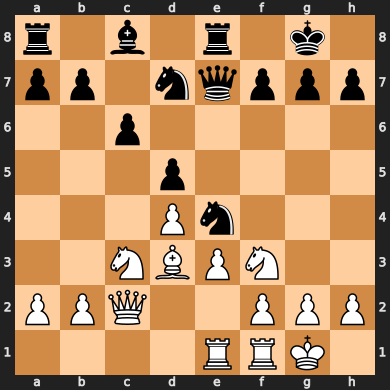

GM Sturua (2531) - GM Danielsen (2499), 19th ch-Euro Seniors +50 (2019)
FEN: r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/4RRK1 w - - 0 1
Similarity: 7.066007804440281


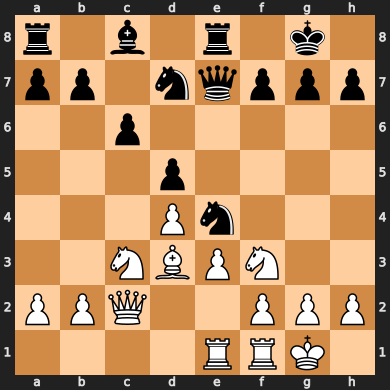

GM Navara (2697) -  Trejbal (1926), Betsys ch-CZE On/L Blitz (2021)
FEN: r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBP3/PPQ1NPPP/R4RK1 w - - 0 1
Similarity: 6.885651346942208


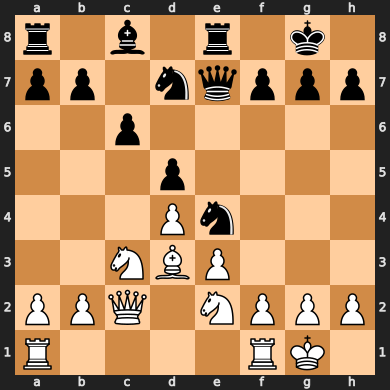

GM Parligras (2575) - IM Cosma (2396), ch-ROU 2022 (2022)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.818323337993748


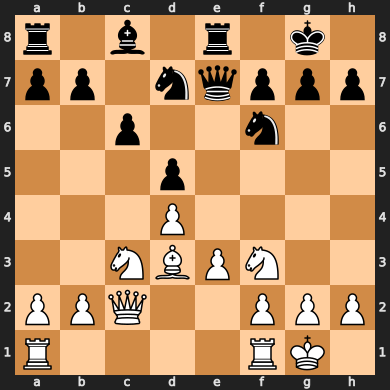

CM Kananub (2206) - GM Schebler (2398), Thailand Pattaya Open (2019)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.818323337993748


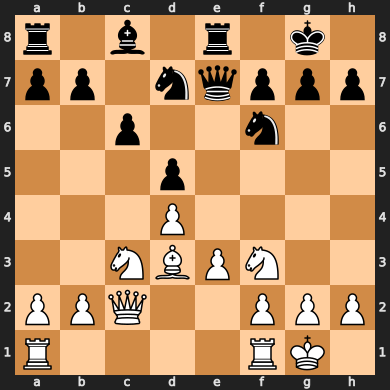

GM Sturua (2531) - GM Danielsen (2499), 19th ch-Euro Seniors +50 (2019)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.818323337993748


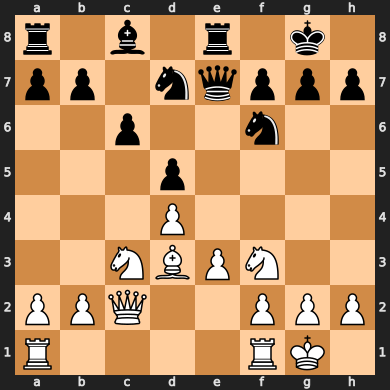

GM Tristan (2535) -  Richards (1451), Am. World Cup QGp2 (2021)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.818323337993748


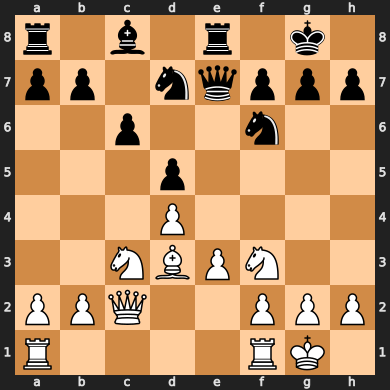

GM Sarana (2640) - GM Rozum (2583), TCh-TUR Super League 2019 (2019)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.818323337993748


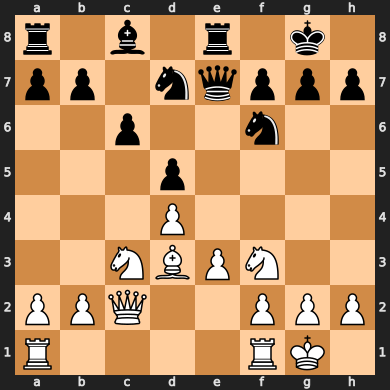

GM Lysyj (2603) - GM Rozum (2529), ch-RUS Rapid 2021 (2021)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.818323337993748


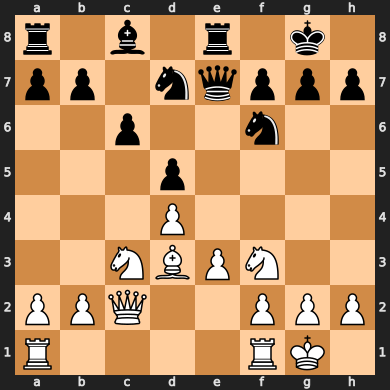

GM Le (2709) - FM Wong (2381), 31st SEA Games Rapid Team (2022)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.818323337993748


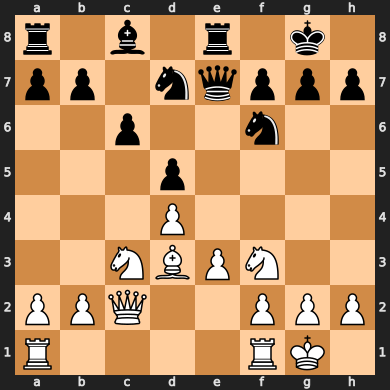

GM Sarana (2640) - GM Rozum (2583), TCh-TUR Super League 2019 (2019)
FEN: r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/P1NBPN2/1PQ2PPP/R4RK1 w - - 0 1
Similarity: 6.770027463476593


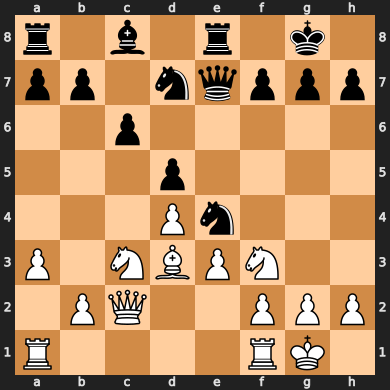

GM Arkell (2467) - FM Kristiansen (2134), World Senior Teams +50 (2019)
FEN: r3r1k1/pp1nqppp/2p5/3p4/3Pn3/2N1PN2/PPQ2PPP/1R3RK1 w - - 0 1
Similarity: 6.697495707663558


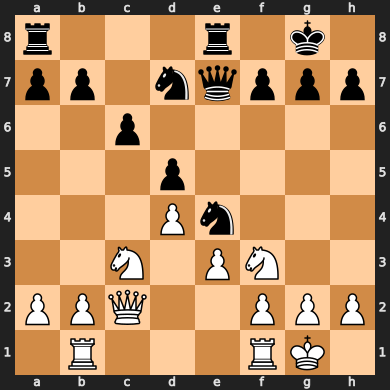

GM Carlsen (2861) - GM Ding Liren (2805), Cote d'Ivoire Blitz 2019 (2019)
FEN: r4rk1/ppq2ppp/2nbpn2/3pN3/3P1B2/2P5/PP1NQPPP/R3R1K1 b - - 0 1
Similarity: 6.676951426730866


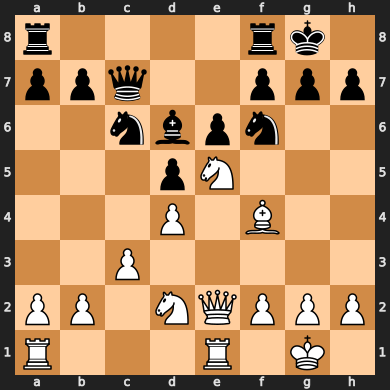

GM Dreev (2655) - GM Vajda (2534), Titled Tuesday 5th May (2020)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/3P4/2NBPN2/PPQ2PPP/1R3RK1 w - - 0 1
Similarity: 6.485171009824663


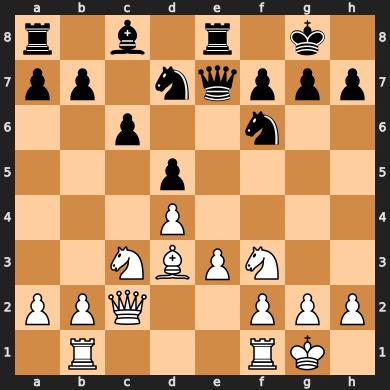

GM Le (2709) - FM Wong (2381), 31st SEA Games Rapid Team (2022)
FEN: r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN1P/PPQ2PP1/R4RK1 w - - 0 1
Similarity: 6.374544738916331


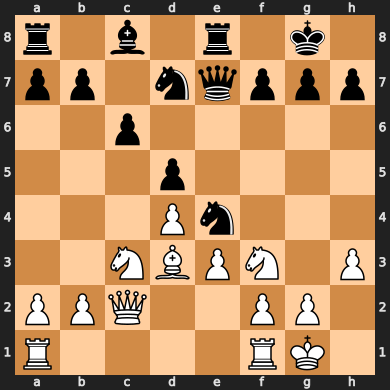

Venkat (2167) - GM Eljanov (2672), PNWCC Online Blitz JP 10 (2020)
FEN: r1b1r1k1/pp1nqppp/2p2n2/3p4/1b1P4/2NBPN2/PPQB1PPP/R4RK1 w - - 0 1
Similarity: 6.368735195357731


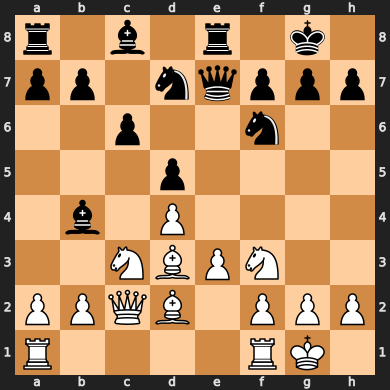

GM Chandra (2513) -  Comsa (1835), ch-Midwest Collegiate (2019)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


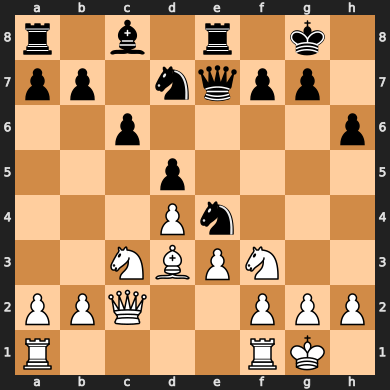

IM Livaic (2576) - GM Sjugirov (2703), Titled Tue 30th Aug Late (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


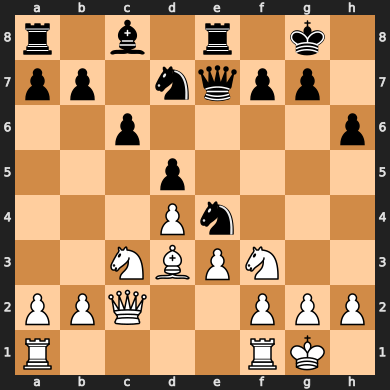

IM Livaic (2507) - GM Bluebaum (2670), Euro Online Blitz Quali (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


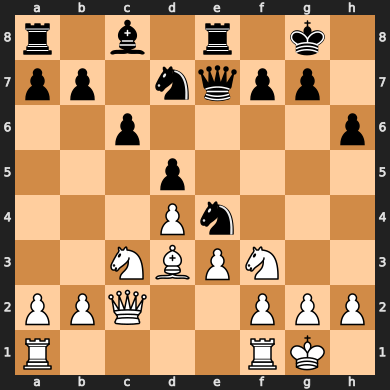

GM Golod (2503) - FM Zlatin (2287), Shavout Ramat Gan 2019 (2019)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


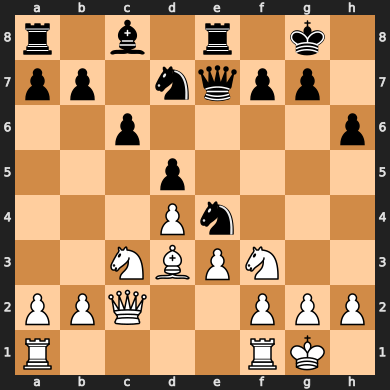

GM Mirzoev (2435) -  Lutsko (2407), 23rd Olomouc A GM 2022 (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


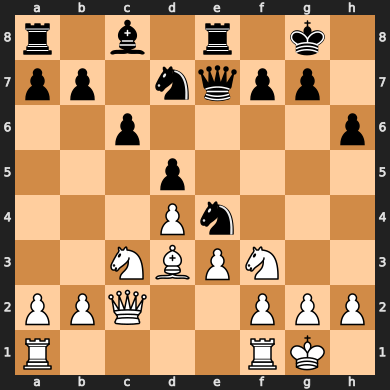

GM Holt (2549) - GM Santiago (2480), Speed Chess Super Swiss (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


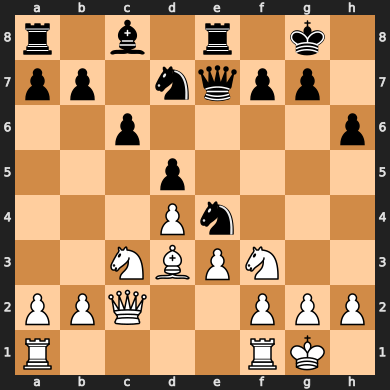

GM Esipenko (2682) - GM Gelfand (2676), PNWCC Online Blitz JP 10 (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


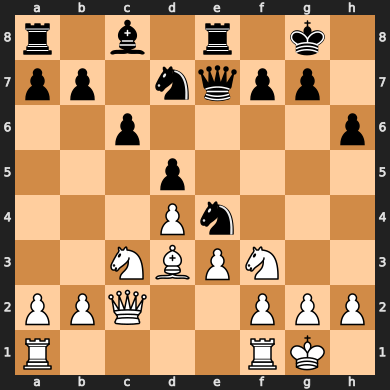

IM Kaasen (2383) - GM Hammer (2608), ch-NOR 2021 (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


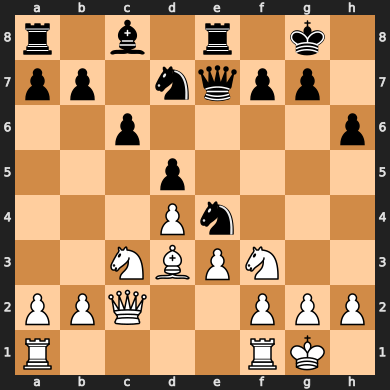

GM Esipenko (2682) - GM Aleksandrov (2608), Kurnosov Mem Rapid 2020 (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


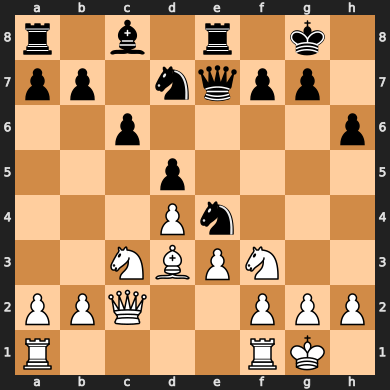

GM Rustemov (2525) - GM Jacobson (2492), Titled Tuesday 12th Oct (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


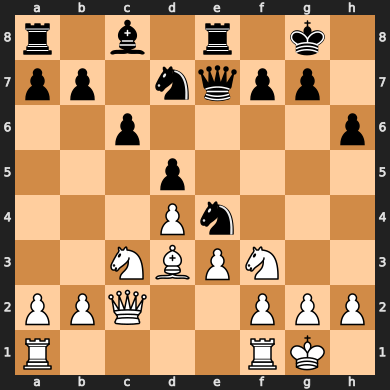

IM Pert (2416) - GM Kuzubov (2628), Titled Tuesday 17th Aug (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


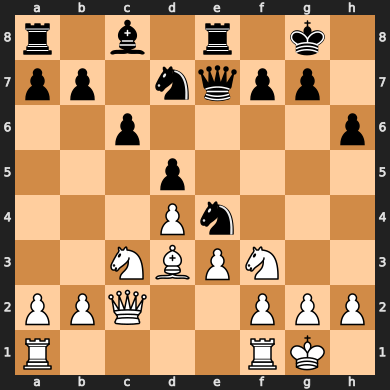

FM Koelle (2312) - GM Jacobson (2504), Titled Tuesday 6th July (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


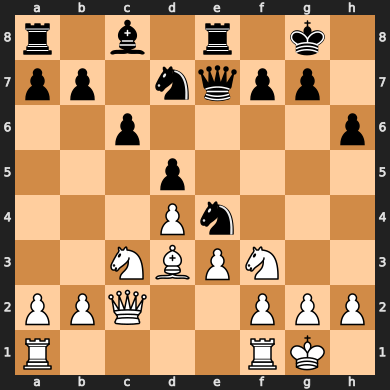

GM Maiorov (2446) -  Awoki (2152), Titled Tuesday 7th Sept (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


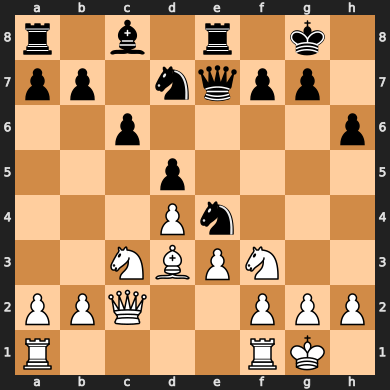

GM Keymer (2568) - GM Narayanan (2618), Chess24 Banter QualD 2020 (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


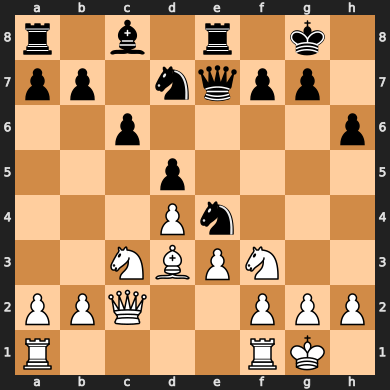

IM Livaic (2565) - GM Vidit (2710), Titled Tue 13th Sep Early (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


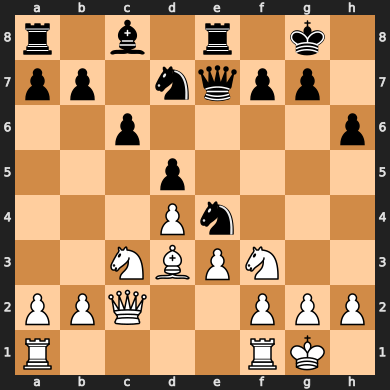

GM Dreev (2635) - GM Nesterov (2514), ch-RUS Rapid 2021 (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


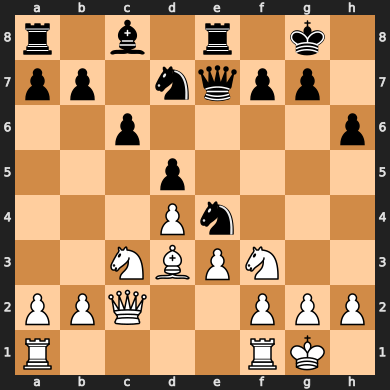

GM Nesterov (2531) - GM Jacobson (2524), chess.com Junior Speed (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


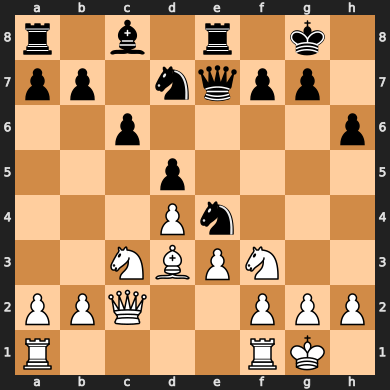

IM Seo (2466) - GM Nesterov (2522), Titled Tue 8th Feb Early (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


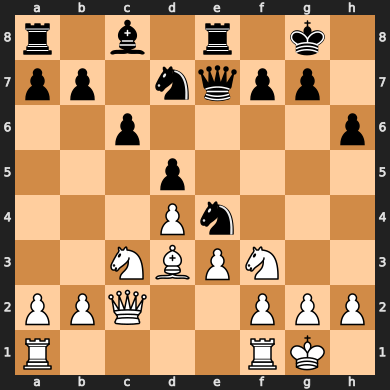

IM Perdomo (2301) - GM Khamrakulov (2514), Titled Tuesday 1st Sept (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


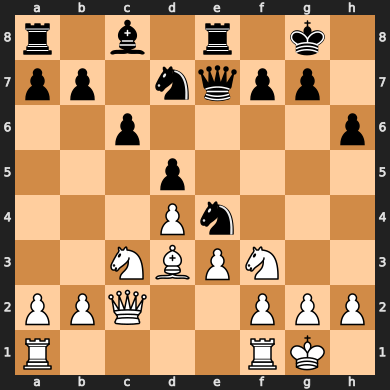

IM Livaic (2507) - GM Matlakov (2685), Speed Chess Super Swiss (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


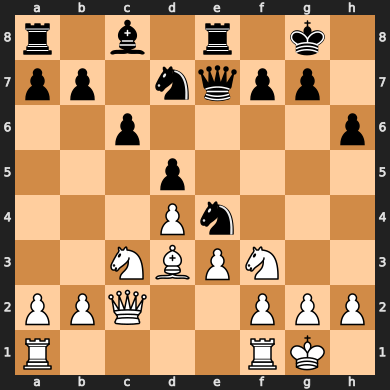

GM Checa (2574) - GM Jacobson (2491), Cherry Blossom Classic (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


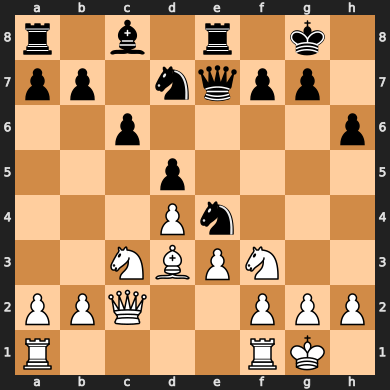

GM Chandra (2536) -  Syaputra (2204), Levitov Christmas Q3 (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


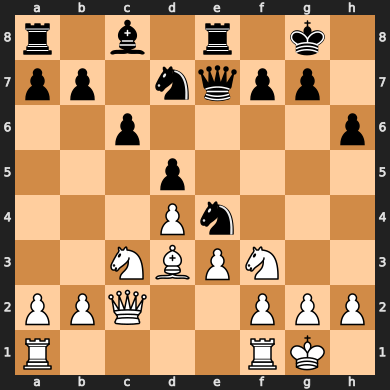

IM Brumen (2299) - GM Votava (2476), TCh-AUT 2nd West 2022-23 (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


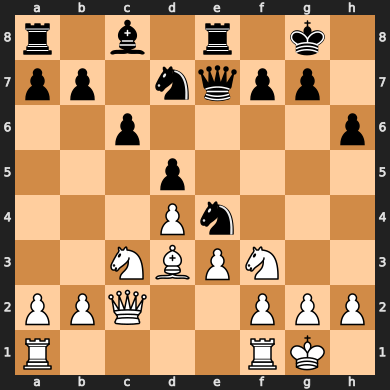

GM Raja (2491) - GM Vidit (2714), Chess.com RCC Wk20 Swiss (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


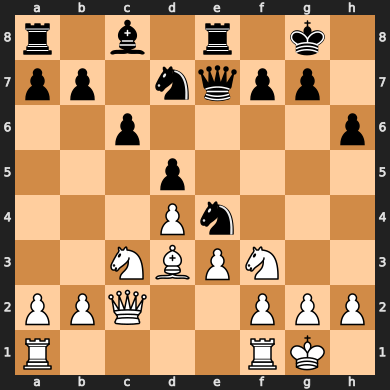

GM Sokolov (2593) - GM Tukhaev (2534), 27th Sharjah Int Rapid (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


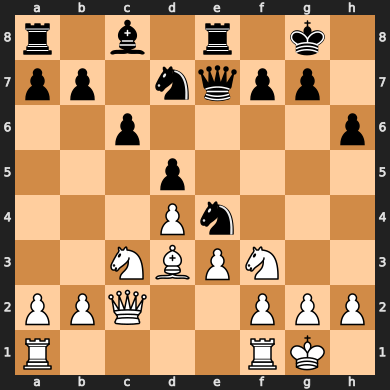

FM Heimann (2424) - GM Stremavicius (2543), 1000GM Bay Area GM 2022 (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


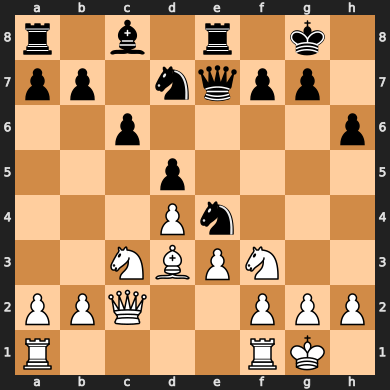

GM Shipov (2541) - GM Dubov (2702), Titled Tue 14th Jun Early (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


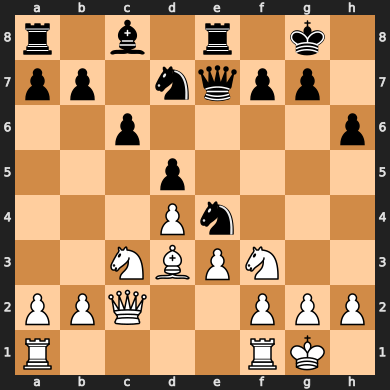

GM Fedoseev (2688) - IM Harshavardhan (2426), chess.com SpeedChess Q1Sw (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


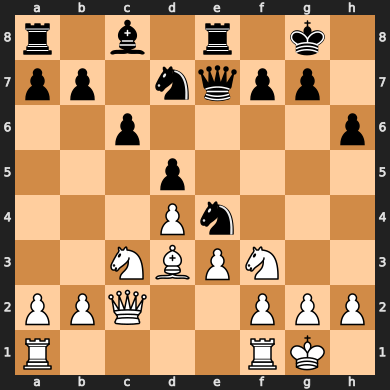

IM Luch (2364) - GM Korobov (2671), Enea TCh-POL Ekstraliga (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


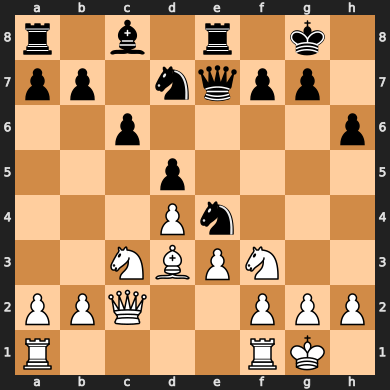

GM Firouzja (2728) - GM Paravyan (2653), Katara Bullet Final 2020 (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


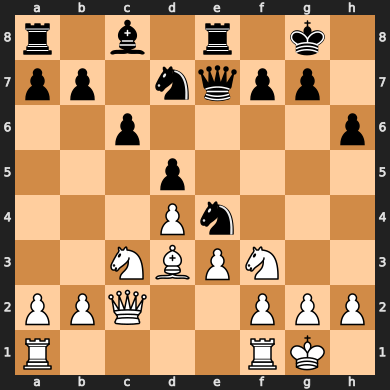

GM Keymer (2568) - GM Narayanan (2618), Chess24 Banter QualD 2020 (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


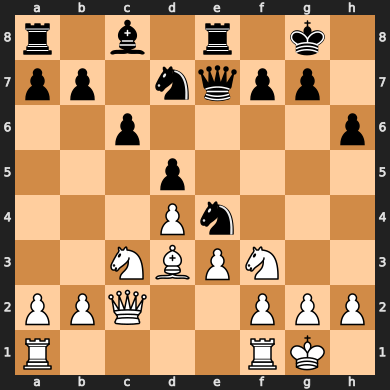

IM Rahul (2463) - GM Jacobson (2481), 51st Continental Open (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


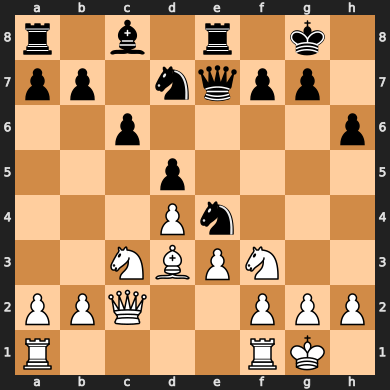

WGM Zhai Mo (2366) - GM Kryakvin (2577), RBI Open Qualifier 3 2020 (2020)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


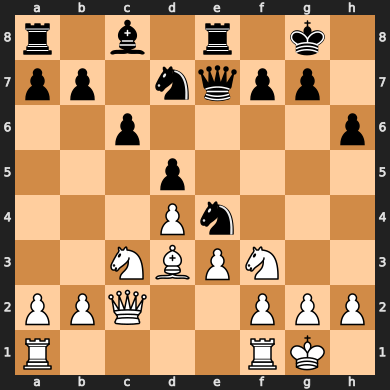

GM Lenderman (2645) - GM Akobian (2618), St Louis Fall A 2019 (2019)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


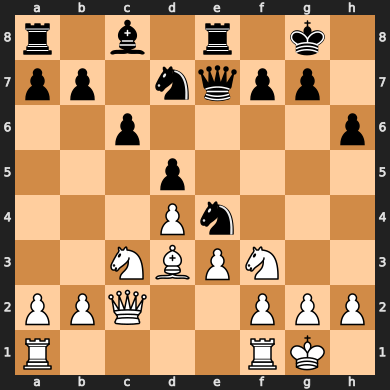

WGM Obolentseva (2330) - GM Nesterov (2567), Ugra Cup Rapid 2022 (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


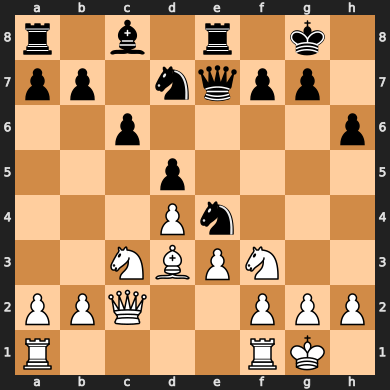

GM Riazantsev (2639) - GM Sebenik (2501), European Blitz 2019 (2019)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


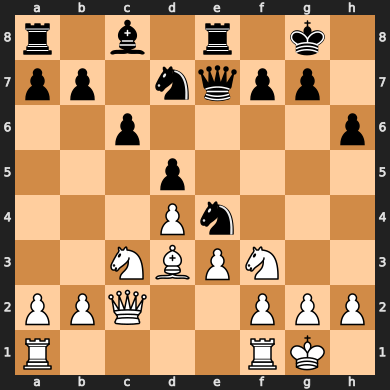

CM Papasimakopoulos (2251) - GM Nesterov (2491), Titled Tuesday 4th May (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


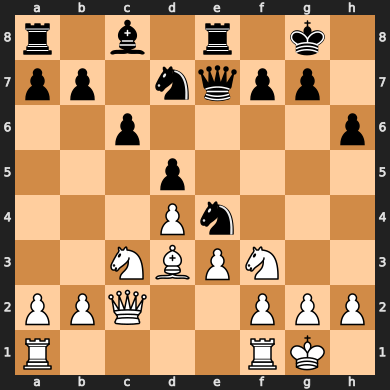

GM Volodin (2457) - GM Ehlvest (2517), Eesti Masters 2021 (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


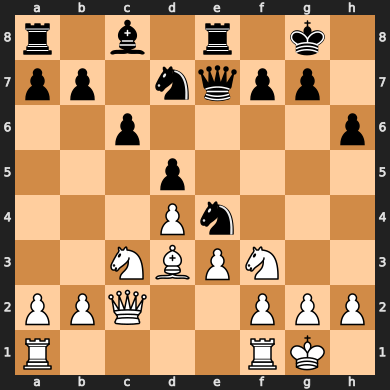

IM Chiku-Ratte (2377) - GM Andreikin (2725), Titled Tuesday 18th May (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


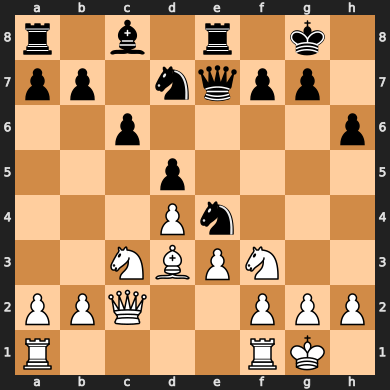

CM Papasimakopoulos (2251) - GM Jacobson (2491), Titled Tuesday 23rd Feb (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


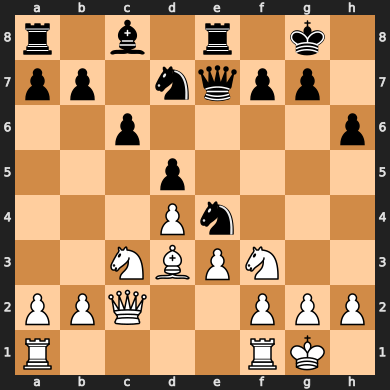

GM Bocharov (2526) - GM Artemiev (2701), TCh-RUS Rapid 2022 (2022)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


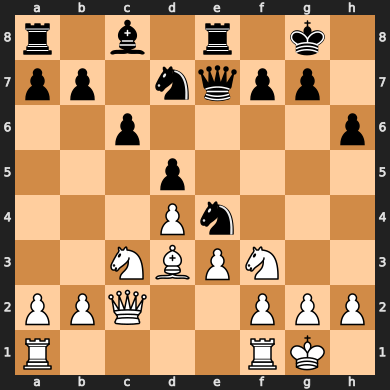

GM Bok (2624) - GM Bluebaum (2674), Titled Tuesday 10th Aug (2021)
FEN: r1b1r1k1/pp1nqpp1/2p4p/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 0 1
Similarity: 6.356786214413408


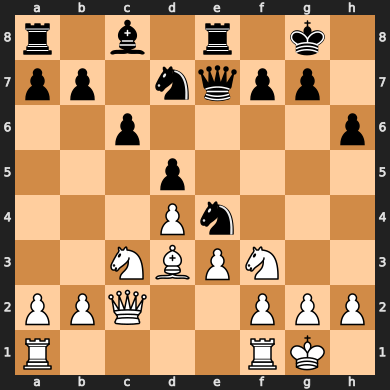

In [15]:
print(query_fen)
display(chess.Board(fen=query_fen))
print('-'*64)

for ind in top_k_indices:
    fen_array = positions[ind]
    id = ids[ind]
    white = df['WhitePlayerName'][id].split(',')[0]
    black = df['BlackPlayerName'][id].split(',')[0]
    welo = df['WhiteRating'][id]
    belo = df['BlackRating'][id]
    wtitle = df['WhiteTitle'][id] if pd.notnull(df['WhiteTitle'][id]) else ''
    btitle = df['BlackTitle'][id] if pd.notnull(df['BlackTitle'][id]) else ''
    year = str(df['Date'][id]).split('.')[0]
    event = df['Event'][id]
    print(f"{wtitle} {white} ({welo}) - {btitle} {black} ({belo}), {event} ({year})".strip())

    vector = reverse_orient_board(fen_array.toarray()[0])
    fen_string = vector_to_fen(vector)
    print("FEN:", fen_string)

    print("Similarity:", weighted_similarities[ind]) #Standard Deviations Above Mean Candidate Position
    display(chess.Board(fen=fen_string))

In [16]:
cur.close()
conn.close()